# 📌 Introduction  

Ce projet vise à analyser la **performance et le risque** d’indices rebalancés en utilisant différentes stratégies d’investissement.  
Il permet d’évaluer l’efficacité des approches quantitatives en comparant leurs résultats avec un indice de référence.  
L’objectif est d’optimiser la sélection des actifs en fonction de critères financiers et sectoriels.  

Pour plus de lisibilité, la plupart des **fonctions sont regroupées dans un fichier annexe** `projet_fonctions.py`.  
Elles peuvent être appelées directement avec `prj.` pour simplifier l'utilisation et la maintenance du code. 

In [1]:
import pandas as pd
from typing import Dict, Tuple, List, Optional
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.figure import Figure
from typing import Callable
import os
from fpdf import FPDF
import plotly.express as px
import plotly.graph_objects as go
import kaleido
import smtplib
from email.message import EmailMessage
from Fonctions import projet_fonctions as prj
import ipywidgets as widgets
from IPython.display import display


# Chargement des données de prix

Nous utilisons la fonction `process_price_data` pour charger les prix des indices **S&P 500 (SPX)** et **STOXX Europe 600 (SXXP)** à partir d'un fichier Excel. Nous avons choisi d'exclure les titres ayant plus de 5% de valeurs manquantes (threshold_ratio=0.95). Cela permet d'éviter des biais liés à une mauvaise qualité des données. Pour le reste nous interpolons afin de combler les vides.

Nous choisissons de convertir la base df_SXXP en dollars (convertie en continue à partir des données du FOREX) pour avoir une base de prix fusionnée en dollars.

In [2]:
file_path = "Copie de Data_projets_M1EEF - fige.xlsx"

df_SPX = prj.process_price_data(file_path, "SPX_PX_LAST", "2010-04-01")
df_SXXP = prj.process_price_data(file_path, "SXXP_PX_LAST", "2010-04-01")

df_FOREX = pd.read_excel(file_path,sheet_name="Forex",index_col=1).loc["2010-04-01":,:]
df_SXXP_dollar= prj.convert_to_currency(df_SXXP, df_FOREX, "EUR", "USD")
df_prices = pd.merge(
    df_SXXP_dollar, 
    df_SPX, 
    left_index=True, 
    right_index=True, 
    how='inner'  # Choisir 'inner' pour ne garder que les dates communes
)


Nous harmonisons et concaténons les donnnées de secteurs pour SPX et SXXP.

In [3]:
df = pd.read_excel(file_path, sheet_name="Members", header=0)
df_secteurs_SPX = df.iloc[:, 0:6].dropna(how='all')
df_secteurs_SXXP = df.iloc[:, 7:13].dropna(how='all')
df_secteurs_SXXP.columns = df_secteurs_SPX.columns
df_secteurs = pd.concat([df_secteurs_SPX, df_secteurs_SXXP], ignore_index=True)
df_secteurs.rename(columns={df_secteurs.columns[0]: 'Index'}, inplace=True)
df_secteurs.set_index(df_secteurs.columns[0], inplace=True)


df_SPX_Benchmark = pd.read_excel(file_path,sheet_name="Index",index_col=0).iloc[:, 0:1].dropna()
df_SPX_Benchmark = df_SPX_Benchmark.sort_index()
df_SPX_Benchmark.index.name = None 


# 🔄 Construction et Rebalancement de nos indices  

Avant d'appliquer une stratégie spécifique, nous utilisons une série de **fonctions génériques** qui permettent de sélectionner les titres, de construire l'indice et d'assurer son rebalancement. 

Une première filtrer_et_selectionner fonction permet de trier un data_frame pour séléctionner les meilleurs actions.
Une seconde calculer_indice nous calcule un indice selon la méthodologie **MSCI**.
Une troisième pour effectuer un rebalancement à toutes les dates souhaitées

1. **Sélection des 50 meilleures actions**.  
2. **Pondération par la capitalisation boursière ajustée** :  
   \[
   w_i = \frac{\text{Market Cap}_i}{\sum \text{Market Cap}_j}
   \]
3. **Calcul de l'indice pondéré** basé sur l'évolution des prix.  
4. **Base 100** pour normaliser l'indice.  
5. Réiteration de cette stratégie à toutes les dates où un rebalancement est souhaité


Ce choix méthodologique est **pertinent**, car ces fonctions sont **indépendantes du style d'investissement** et permettent d’adapter facilement le modèle à différentes stratégies.



## Visualisation et performance
On peut visualiser nos indices sous plusieurs formes.
La fonction tracer_indices_comparaison permet de comparer les différents indices calculés après les rebalancements successifs et de les visualiser graphiquement.

Les fonctions plot_country_piechart et plot_sector_piechart permettent de visualiser les différents pays et secteurs qui composent notre indice.

Enfin la fonction performance permet de comparer notre indice à un Benchmark défini par l'utilisateur

# 📊 Stratégie Value

## 🔹 Principe  
Cette stratégie suit une méthodologie inspirée de **MSCI**, basée sur **trois facteurs** :  
- **Price-to-Book (P/B)**  
- **Price-to-Earnings (P/E)**  
- **Dividend Yield (DY)**  

Nous utilisons des **Scores Z** pour standardiser ces indicateurs et identifier les **50 meilleures actions Value**.

---

## 🔢 Calcul du Score Z  
Chaque indicateur est transformé en score Z :

\[
Z_X = \frac{X_i - \bar{X}}{\sigma_X}
\]

avec :
- \( Z_{\text{P/B}} = \frac{1/\text{P/B} - \overline{1/\text{P/B}}}{\sigma(1/\text{P/B})} \)  
- \( Z_{\text{P/E}} = \frac{1/\text{P/E} - \overline{1/\text{P/E}}}{\sigma(1/\text{P/E})} \)  
- \( Z_{\text{DY}} = \frac{\text{DY} - \bar{\text{DY}}}{\sigma(\text{DY})} \)  

Le **Score Z Value** est la moyenne de ces trois valeurs.

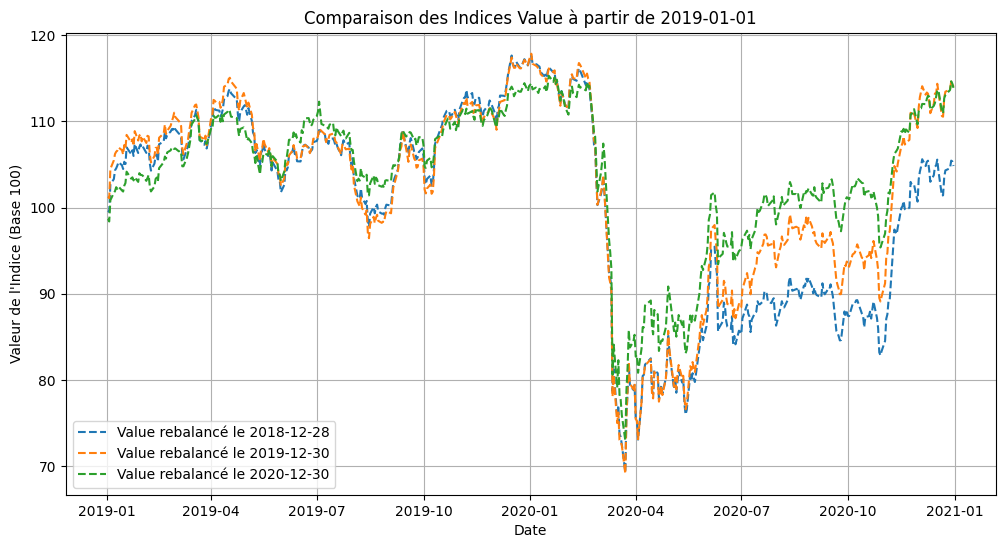

In [4]:
rebalance_dates = ["2018-12-28", "2019-12-30", "2020-12-30"]

df_qual_dict = {
    date: prj.process_qualitative_data(file_path, f"Qualitativ_{date[:4]}", df_prices, df_FOREX, date, df_SXXP)
    for date in rebalance_dates
}
indices_value_rebal = prj.rebalancer_indice(df_prices, df_qual_dict, df_secteurs, rebalance_dates, prj.style_value, n_actions=50)
prj.tracer_indices_comparaison(indices_value_rebal, "Value", "2019-01-01", "2021-01-01")

# 📊 Stratégie High Dividend Low Volatility  

## 🔹 Principe  
Cette stratégie combine les actions avec un **rendement en dividendes élevé** et une **faible volatilité**, en s'inspirant des méthodologies MSCI. Elle repose sur **deux facteurs** :  
- **Dividend Yield (DY)**  
- **Volatilité Historique (HV, Historical Volatility)**  

Nous utilisons des **Scores Z** pour identifier les **50 meilleures actions combinant un haut dividende et une faible volatilité**.

---

## 🔢 Calcul du Score Z  
Chaque indicateur est transformé en score Z :

\[
Z_X = \frac{X_i - \bar{X}}{\sigma_X}
\]

avec :
- \( Z_{\text{DY}} = \frac{\text{DY} - \bar{\text{DY}}}{\sigma(\text{DY})} \)  
- \( Z_{\text{HV}} = \frac{-\text{HV} - (-\bar{\text{HV}})}{\sigma(-\text{HV})} = \frac{\bar{\text{HV}} - \text{HV}}{\sigma(\text{HV})} \)  

Le **Score Z High Dividend Low Volatility** est la moyenne de ces deux valeurs.


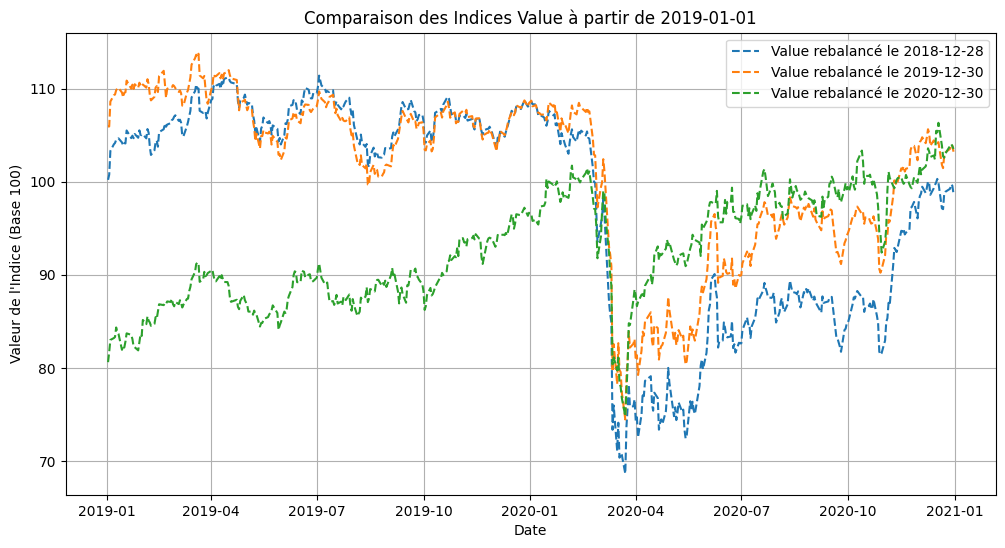

In [5]:
indices_high_div_low_vol_rebal = prj.rebalancer_indice(df_prices, df_qual_dict, df_secteurs, rebalance_dates, prj.style_high_div_low_vol, n_actions=50)
prj.tracer_indices_comparaison(indices_high_div_low_vol_rebal, "Value")
prj.plot_sector_piecharts(indices_high_div_low_vol_rebal, df_secteurs, "High Dividend Low Volatility")
prj.plot_country_piecharts(indices_high_div_low_vol_rebal, df_qual_dict, "High Dividend Low Volatility")

# 📊 Stratégie Momentum Sectoriel  

## 🔹 Principe  
La stratégie **Momentum Sectoriel** sélectionne les actions ayant la **meilleure performance sur les 12 derniers mois**, tout en filtrant selon des **secteurs spécifiques** définis par **BICS (Bloomberg Industry Classification Standard)**.

Cette approche repose sur **un seul facteur** :
- **Momentum sur 12 mois** (basé sur le rendement cumulé)

Nous utilisons ce critère pour identifier les **meilleures actions en tendance haussière** dans les secteurs ciblés.

---

## 🔢 Calcul du Momentum  
Le **momentum** est calculé comme la somme des variations de prix sur **12 mois** :

\[
\text{Momentum}_i = \sum_{t=-12}^{t=0} \frac{P_{i,t} - P_{i,t-1}}{P_{i,t-1}}
\]

où :
- \( P_{i,t} \) est le prix de l’action \( i \) au mois \( t \).
- \( \text{Momentum}_i \) représente la performance cumulée sur 12 mois.

Les actions sont ensuite **triées par ordre décroissant** de Momentum.



Vous pouvez séléctionner directement les secteurs sur lesquels vous voulez baser votre indice via une liste déroulante !

In [8]:
bics_options = unique_bics = sorted(df_secteurs['BICS_LEVEL_3_INDUSTRY_NAME'].unique())
checkboxes = [widgets.Checkbox(value=False, description=sector) for sector in bics_options]
button = widgets.Button(description="Appliquer")
display(widgets.VBox(checkboxes), button)
def on_button_click(b):
    global selected_sectors  # Accès à la variable globale
    selected_sectors = [cb.description for cb in checkboxes if cb.value]
button.on_click(on_button_click)


Button(description='Appliquer', style=ButtonStyle())

['Real Estate Owners & Developers', 'Real Estate Services', 'Renewable Energy', 'Retail - Consumer Staples']


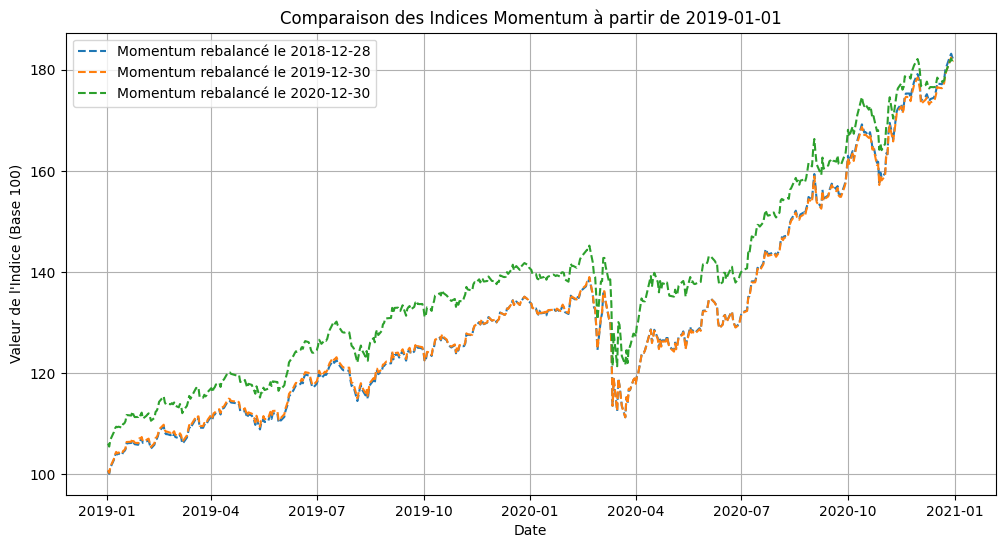

                           Performance Totale  Performance Annualisée  \
Indice Dec 2018                      0.854877                0.229084   
Indice Rebalancé Dec 2020            0.880141                0.234648   
Benchmark                            0.898854                0.238737   

                           Volatilité  Max Drawdown      Beta     Alpha  \
Indice Dec 2018              0.168867     -0.198365  0.493390  0.107362   
Indice Rebalancé Dec 2020    0.162225     -0.164211  0.490645  0.113603   
Benchmark                    0.224589     -0.339250  1.000000 -0.000492   

                           Ratio de Sharpe  
Indice Dec 2018                   1.206225  
Indice Rebalancé Dec 2020         1.276732  
Benchmark                         0.976134  


In [10]:
print(selected_sectors)
bics_criteria = selected_sectors

indices_momentum_rebal = prj.rebalancer_indice(df_prices, df_qual_dict, df_secteurs, rebalance_dates, prj.style_momentum_sector, bics_criteria, n_actions=50)

prj.tracer_indices_comparaison(indices_momentum_rebal, "Momentum")


# Calcul des performances pour les deux indices
resultats_performance = {
    "Indice Dec 2018": prj.calculer_performance_risque(indices_momentum_rebal[rebalance_dates[0]]['indice'], df_SPX_Benchmark, "2019-01-01", "2021-12-31"),
    "Indice Rebalancé Dec 2020": prj.calculer_performance_risque(indices_momentum_rebal[rebalance_dates[-1]]['indice'], df_SPX_Benchmark, "2019-01-01", "2021-12-31"),
    "Benchmark" : prj.calculer_performances_benchmark(df_SPX_Benchmark, "2019-01-01", "2021-12-31")
}

# Convertir en DataFrame pour affichage
df_performance = pd.DataFrame(resultats_performance).T
print(df_performance)

# 📊 Application de l'Indice Momentum

Nous appliquons l'**indice Momentum** aux **secteurs technologiques en forte croissance**, notamment :  
- **Semiconductors**
- **Software**
- **Technology Services**

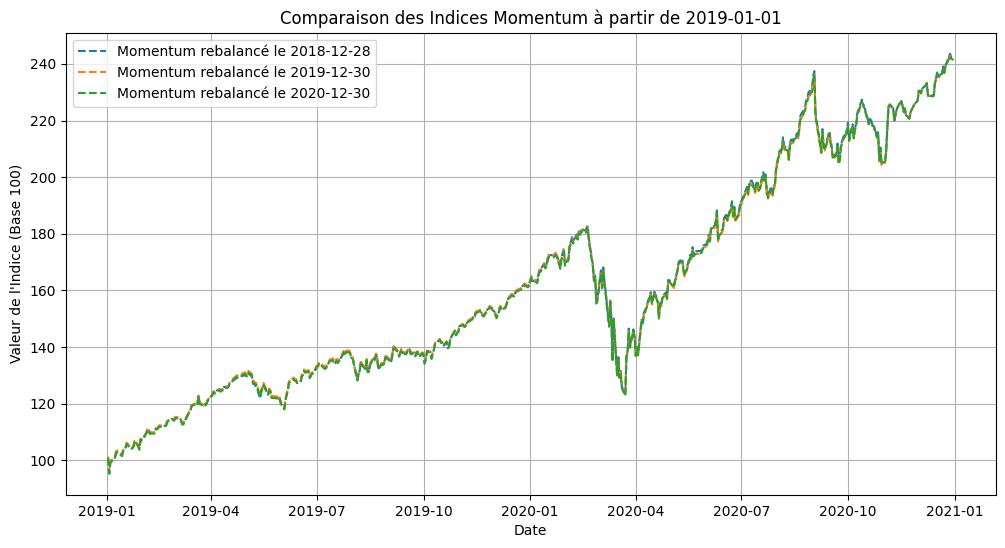

In [ ]:
bics_criteria = ["Semiconductors", "Software", "Technology Services", "Technology Hardware"]
indices_momentum_tech_rebal = prj.rebalancer_indice(df_prices, df_qual_dict, df_secteurs, rebalance_dates, prj.style_momentum_sector, bics_criteria, n_actions=50)

prj.tracer_indices_comparaison(indices_momentum_tech_rebal, "Momentum")

# 📊 Rapport de Risque & Performance des Indices Rebalancés  

Ce rapport analyse la **performance** et le **risque** des indices après rebalancement. Il permet d’évaluer si la stratégie sélectionnée apporte une **surperformance** par rapport au marché et quel est son niveau de **volatilité**.  

L’utilisateur peut **modifier les paramètres** notamment le style et le benchmark pour tester différentes stratégies, périodes de rebalancement ou filtres sectoriels.

---

## 📈 Contenu du Rapport  

### 📌 Évolution des Indices  
Comparaison graphique des indices rebalancés avec un **indice de référence** afin de visualiser les écarts de performance.  

### 📌 Analyse du Risque  
Évaluation de la **volatilité** et d'autres indicateurs de risque pour comprendre la stabilité de la stratégie.  

### 📌 Indicateurs de Performance  
Présentation de métriques clés comme le **rendement total, le ratio de Sharpe pour juger l’efficacité de l’approche.  

### 📌 Composition du Portefeuille  
Vue d’ensemble des **secteurs et actions** sélectionnés après chaque rebalancement.  

---

Ce rapport peut être ajusté selon les besoins en **modifiant les paramètres d’entrée**.  

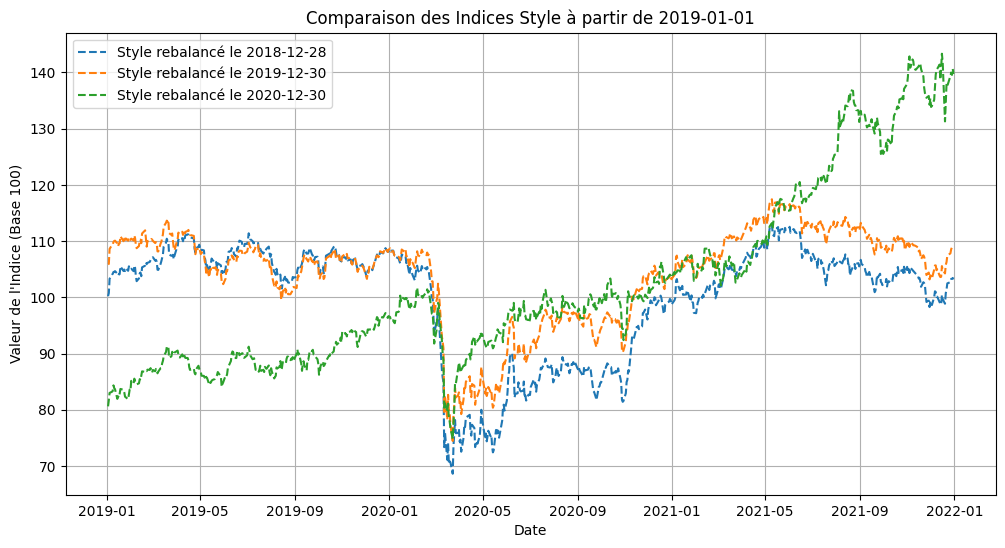

In [11]:

prj.creation_pdf(prj.style_high_div_low_vol, rebalance_dates, df_prices, df_qual_dict, df_SPX_Benchmark, df_secteurs)


# 📧 Envoi du Rapport par Email  

Une fois le **Rapport de Risque & Performance** généré, il peut être **envoyé automatiquement par email**.  
Cela permet de **partager facilement l’analyse** avec d’autres utilisateurs ou de l’archiver pour un suivi.  

L’envoi de l’email est **désactivé par défaut** (commenté), mais l’utilisateur peut l’activer en retirant le `#`.

In [60]:
#prj.envoi_mail(SMTP_SERVER = "smtp.gmail.com", SMTP_PORT = 587, EMAIL_SENDER = "karimhajji.kh@gmail.com", EMAIL_PASSWORD = "gfoghlppvdedzvak", EMAIL_RECEIVER = "karim.hajji@dauphine.eu", FILE_PATH = "Rapport_Risque_Performance.pdf")